In [4]:
# Import python libraries
import numpy as np
import datetime
import sys
import glob
import os
import h5py
from collections import OrderedDict
import hdf5plugin
import copy
import pickle
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import cfgrib
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

In [5]:
# Remove warning comments
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import sys
sys.tracebacklimit = 0

In [6]:
def grid_decomp(filein,ex_pts,grid_spacing):
    # Grab initial file at the beginning of the analysis period
    rams_file = h5py.File(filein, 'r')

    # Grab lat lon variables from case initial file
    lat = np.array(rams_file['GLAT'])
    lon = np.array(rams_file['GLON'])
    dom_rat = np.shape(lon)[0]/np.shape(lon)[1]

    # Calculate domain size
    ny = np.shape(lat)[0]
    nx = np.shape(lat)[1]

    # Calculate lat lon bounds 
    lat_avg = np.nanmean(lat,axis=1)
    lon_avg = np.nanmean(lon,axis=0)

    # Ignore 100 points near grid boundaries ((exclude 10 km near the boundaries))
    lat0 = lat_avg[ex_pts]
    lat1 = lat_avg[ny-ex_pts]

    lon0 = lon_avg[ex_pts]
    lon1 = lon_avg[nx-ex_pts]

    varns = ['UP','VP','RV','WP','THETA','temp','pres','RTC']
#    varns = []

    lon_arr = np.arange(lon0,lon1+0.1,grid_spacing)
    lat_arr =  np.arange(lat0,lat1+0.1,grid_spacing)

    return lon_avg,lat_avg,lon_arr,lat_arr,lon0,lat0,lon1,lat1,nx,ny


In [10]:
# Simulation Case Names
cases = ['USA1.1-R','ARG1.1-R_old','ARG1.2-R','BRA1.1-R','BRA1.2-R',
        'DRC1.1-R','RSA1.1-R','PHI1.1-R','PHI2.1-R','AUS1.1-R','WPO1.1-R']

# Casename Abbrevians for legent
casesn = ['USA1','ARG1','ARG2','BRA1','BRA2','DRC1','RSA1','PHI1','AUS1','PHI2','WPO1']

# ERA5 filenames with at with the same dates of the simulations
Efilenames = ['20220916','2018121314','2018121314','20140331','20140401',
              '20161230','2008031011','20190909-10_SL','20190909-10_SL','20060123','20180827-28']
    
# Times of the Model analysis in ERA5 time formatting
mtimes = ['2022-09-16T11','2018-12-13T19','2018-12-14T01','2014-03-31T17','2014-04-01T14',
         '2016-12-30T11','2008-03-11T12','2019-09-10T12','2019-09-10T15','2006-01-23T12','2018-08-28T07']

# Data and Save path
plotpath = '/tempest/pmarin/monsoon/ENV/Plots/FINAL/'
savepathd = '/tempest/pmarin/monsoon/ENV/Doms/' # Savepath for saving domain images
savepathp = '/tempest/pmarin/monsoon/ENV/' # Savepath for saving profile fidata
savename = 'all_100'

#Specify analysis regions dimension and exclusion points
gs_reanal = 0.25 # Degrees
ex_pts = 100 # exlcude # grid points near edges (100=10km)


In [19]:
plt.rcParams.update({'font.size': 16})

# Create maps of ERA5 decomposition for saving
varnames = ['spd','rh']
#varnames = ['rh']

mplvls = [850,500]
#mplvls = [500]

#varnames = ['rh']
dist_avg = OrderedDict()
dist_med = OrderedDict()
dist_std = OrderedDict()
dist_cnt = OrderedDict()
for varname in varnames:
    # Loop through cases
    for mplvl in mplvls:
        
        print(varname,mplvl)
        dist_avg[varname,mplvl] = np.zeros((2,len(cases)))
        dist_med[varname,mplvl] = np.zeros((2,len(cases)))
        dist_std[varname,mplvl] = np.zeros((2,len(cases)))
        dist_cnt[varname,mplvl] = np.zeros((2,len(cases)))
        
        if varname == 'spd':
            if mplvl == 850:
                v = 17 #850 hPa Winds
            elif mplvl == 500:
                v = 18 #500 hPa Winds
        if varname == 'rh':
            if mplvl == 850:
                v = 9 #850 hPa RH
            elif mplvl == 500:
                v = 10 #500 hPa RH
        
        for c in np.arange(0,len(cases)):
#        for c in np.arange(1,2):
            cn = cases[c]
            print(cn)
            files = sorted(glob.glob('/monsoon/MODEL/LES_MODEL_DATA/V0/'+cn+'-V0/G3/out_30s/a-A*g3.h5'))
            filein = files[0] # Choose first lite file
            #filebase = os.path.basename(filein)
            #datestr = filebase[4:8]+filebase[9:11]+filebase[12:14]
            #print(filein,datestr)

            # Calculate lat /lon bounds
            lon_avg,lat_avg,lon_arr,lat_arr,lon0,lat0,lon1,lat1,nx,ny = grid_decomp(filein,ex_pts,gs_reanal)

            maxlon = np.max(lon_arr)
            minlon = np.min(lon_arr)
            maxlat = np.max(lat_arr)
            minlat = np.min(lat_arr)

            era5file = '/monsoon/MODEL/LES_MODEL_DATA/V0/'+cn+'-V0/ERA5/ERA5_'+Efilenames[c]+'.grib'
            mtime = np.datetime64(mtimes[c])

            ds = xr.load_dataset(era5file, engine="cfgrib")
            temp = ds['t']

            # Find index where ERA5 time matches desired RAMS time
            etime = temp['time'] # Era5 time array
            idtime = np.where(etime == mtime)[0]
            print(idtime)

            # Find index where ERA5 level matches desired RAMS levels
            eplvl = temp['isobaricInhPa'] # Era5 time array
            idplvl = np.where(eplvl == mplvl)[0]
            print(idplvl)

            # Find index where ERA5 lat lons within the RAMS inner grid
            elat = temp['latitude'] # Era5 time array
            elon = temp['longitude'] # Era5 time array
            idslat = np.where((elat <= maxlat) & (elat >= minlat))[0]
            idslon = np.where((elon <= maxlon) & (elon >= minlon))[0]   

            if varname == 't':
                var = ds['t'][idtime,idplvl,idslat,idslon]
                bins = np.arange(260,294.01,0.2)
            if varname == 'spd':
                var = np.sqrt(np.power(ds['u'][idtime,idplvl,idslat,idslon],2.0) + 
                            np.power(ds['v'][idtime,idplvl,idslat,idslon],2.0))
                bins = np.arange(0,40.1,1)

            if varname == 'rh':
                p_mp = mplvl*units.hPa

                t_mp = ds['t'][idtime,idplvl,idslat,idslon].values-273.15
#                t_mp = ds['t'][idtime,idplvl,:,:].values-273.15
                t_mp = t_mp*units.degC

                # Calculate vapor pressure
                mixing = ds['q'][idtime,idplvl,idslat,idslon].values*units('kg/kg')
                #print(mixing)
#                mixing = ds['q'][idtime,idplvl,:,:].values*units('kg/kg')
                e_mp = mpcalc.vapor_pressure(p_mp, mixing)
                e_mp[e_mp==0]=np.NaN
                e_mp[np.isnan(e_mp)]=np.nanmin(e_mp)

                es_mp = mpcalc.saturation_vapor_pressure(t_mp).to('hPa')
                var = (e_mp/es_mp).magnitude
                bins = np.arange(0,1.01,0.05)

            #print(var)
            
                
            ecnts, ebine = np.histogram(var,bins=bins)
            ecnts = np.insert(0,0,ecnts)   

            # Load "ERA5-Mean" Values from model data (from 1km areas)
            #varsin = ['tcwcs','tcls','tcwvs','spd_sfcs','mlcapesGB','rh_850s','rh_500s','shr_lls','mucapesGB']
            varin = varname+'_'+str(int(mplvl))+'s'
            saveadds = '_all_100'
            savepath = '/tempest/pmarin/monsoon/ENV/'+cn+'/'+saveadds[1:]+'/'
            Einfilename = savepath+cn+'_Environments_ERA5'+saveadds+'.p'

            # Load Mean Environmental Variables for entire ERA5-sized boxes
            #with open(Einfilename, 'rb') as f:
            #    mvar = pickle.load(f) # Load environmental variable dictionary
            #mvarE5_cn = mvar[varin][cn]
            
            # Load Mean Environmental Variables for entire ERA5-sized boxes (with condensate thresholding)
            saveadds = '_all_100'
            savepickpath = '/tempest/pmarin/monsoon/ENV/'
            cscrs = 'c0.0001'
            scr_thr = 0.25 # % of reanalysis grid that must be condensate free to include in analysis
            pickfile = savepickpath+'Var_Stats_240205/Var_Stats_'+cscrs+saveadds+'.p'
            f = open(pickfile, 'rb')
            [avg_save, std_save, ran_save, ske_save, kur_save, cnt_save, min_save, p01_save, p05_save, p95_save, p99_save, max_save, q1_save, q3_save, qcd_save, cd_save, stdmm_save, stdmma_save, stdp99_save, stdp95_save, stdp90_save, stdp75_save, cdmma_save, qcdmma_save] = pickle.load(f)
            f.close()
            
            gs = 4 # Sub ERA5-Grid Spacing (4 = 729 1 km sized boxes)
            
            datain = avg_save[cn,v][gs,:]
            cntin = cnt_save[cn,v][gs,:]
            datain[cntin < scr_thr*729] = np.nan # Remove reanalysis areas with 25% of area removed by condensate   
            mvarE5_cn = datain

            mcnts, mbine = np.histogram(mvarE5_cn,bins=bins)
            mcnts = np.insert(0,0,mcnts)   

            dist_avg[varname,mplvl][0,c] = np.nanmean(var)
            dist_avg[varname,mplvl][1,c] = np.nanmean(mvarE5_cn)
 
            dist_med[varname,mplvl][0,c] = np.nanmedian(var)
            dist_med[varname,mplvl][1,c] = np.nanmedian(mvarE5_cn)
 
            dist_std[varname,mplvl][0,c] = np.nanstd(var)
            dist_std[varname,mplvl][1,c] = np.nanstd(mvarE5_cn)

            dist_cnt[varname,mplvl][0,c] = np.count_nonzero(~np.isnan(var))
            dist_cnt[varname,mplvl][1,c] = np.count_nonzero(~np.isnan(mvarE5_cn))
        
        
            fig = plt.figure(figsize=[6,4])
            plt.step(ebine,ecnts,label='ERA5 ('+str(int(np.sum(ecnts)))+')')
            plt.step(mbine,mcnts,label='Model ('+str(int(np.sum(mcnts)))+')')
            plt.title(cn+': '+varname+str(int(mplvl))+'hPa')
            plt.legend()
            plt.grid()
            plt.savefig('/tempest/pmarin/ENV/CMP_ERA5_Model/Plots/'+varname+str(int(mplvl))+'hPa'+'_'+cn+'.png')
            plt.close(fig)

spd 850
USA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[6]
ARG1.1-R_old


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[19]
[6]
ARG1.2-R


Ignoring index file '/monsoon/MODEL/LES_MODEL_DATA/V0/ARG1.2-R-V0/ERA5/ERA5_2018121314.grib.9093e.idx' older than GRIB file
skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[25]
[6]
BRA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[17]
[6]
BRA1.2-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[14]
[6]
DRC1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[6]
RSA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[6]
PHI1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[6]
PHI2.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[39]
[6]
AUS1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[12]
[6]
WPO1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[31]
[6]
spd 500
USA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[15]
ARG1.1-R_old


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[19]
[15]
ARG1.2-R


Ignoring index file '/monsoon/MODEL/LES_MODEL_DATA/V0/ARG1.2-R-V0/ERA5/ERA5_2018121314.grib.9093e.idx' older than GRIB file
skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[25]
[15]
BRA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[17]
[15]
BRA1.2-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[14]
[15]
DRC1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[15]
RSA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[15]
PHI1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[15]
PHI2.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[39]
[15]
AUS1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[12]
[15]
WPO1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[31]
[15]
rh 850
USA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[6]
ARG1.1-R_old


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[19]
[6]
ARG1.2-R


Ignoring index file '/monsoon/MODEL/LES_MODEL_DATA/V0/ARG1.2-R-V0/ERA5/ERA5_2018121314.grib.9093e.idx' older than GRIB file
skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[25]
[6]
BRA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[17]
[6]
BRA1.2-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[14]
[6]
DRC1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[6]
RSA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[6]
PHI1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[6]
PHI2.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[39]
[6]
AUS1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[12]
[6]
WPO1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[31]
[6]
rh 500
USA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[15]
ARG1.1-R_old


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[19]
[15]
ARG1.2-R


Ignoring index file '/monsoon/MODEL/LES_MODEL_DATA/V0/ARG1.2-R-V0/ERA5/ERA5_2018121314.grib.9093e.idx' older than GRIB file
skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[25]
[15]
BRA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[17]
[15]
BRA1.2-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[14]
[15]
DRC1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[11]
[15]
RSA1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[15]
PHI1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[36]
[15]
PHI2.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[39]
[15]
AUS1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[12]
[15]
WPO1.1-R


skipping variable: paramId==170 shortName='stl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)
skipping variable: paramId==40 shortName='swvl2'
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='depthBelowLandLayer' value=Variable(dimensions=(), data=0.0) new_value=Variable(dimensions=(), data=7.0)


[31]
[15]


In [20]:
# Print Mean and Median Percentage Changes
varname = 'spd'
mplvl = 500

test_var = (dist_avg[varname,mplvl][1,:] - dist_avg[varname,mplvl][0,:])/dist_avg[varname,mplvl][0,:]
print(np.mean(test_var),np.median(test_var))

test_var = (dist_med[varname,mplvl][1,:] - dist_med[varname,mplvl][0,:])/dist_med[varname,mplvl][0,:]
print(np.mean(test_var),np.median(test_var))

test_var = (dist_std[varname,mplvl][1,:] - dist_std[varname,mplvl][0,:])/dist_std[varname,mplvl][0,:]
print(np.mean(test_var),np.median(test_var))


0.042015101449743186 -0.0057447290332789235
-0.017899966043452828 -0.0301821606514968
0.3003284565757321 -0.03918894737164225


In [21]:

varname = 'rh'
mplvl = 500

test_var = (dist_avg[varname,mplvl][1,:] - dist_avg[varname,mplvl][0,:])/dist_avg[varname,mplvl][0,:]
print(np.mean(test_var),np.median(test_var))
#print(test_var)

test_var = (dist_med[varname,mplvl][1,:] - dist_med[varname,mplvl][0,:])/dist_med[varname,mplvl][0,:]
#print(test_var)
print(np.mean(test_var),np.median(test_var))

test_var = (dist_std[varname,mplvl][1,:] - dist_std[varname,mplvl][0,:])/dist_std[varname,mplvl][0,:]
print(np.mean(test_var),np.median(test_var))


0.6647240807221502 0.012887997563147752
0.7924525243209327 0.0010737445920831832
0.8176210029405842 0.0670476445518103


[54. 42. 90. 36. 64. 54. 88. 25. 81. 56. 42.]
[54. 21. 64. 36. 40. 54. 78. 14. 31. 14. 42.]


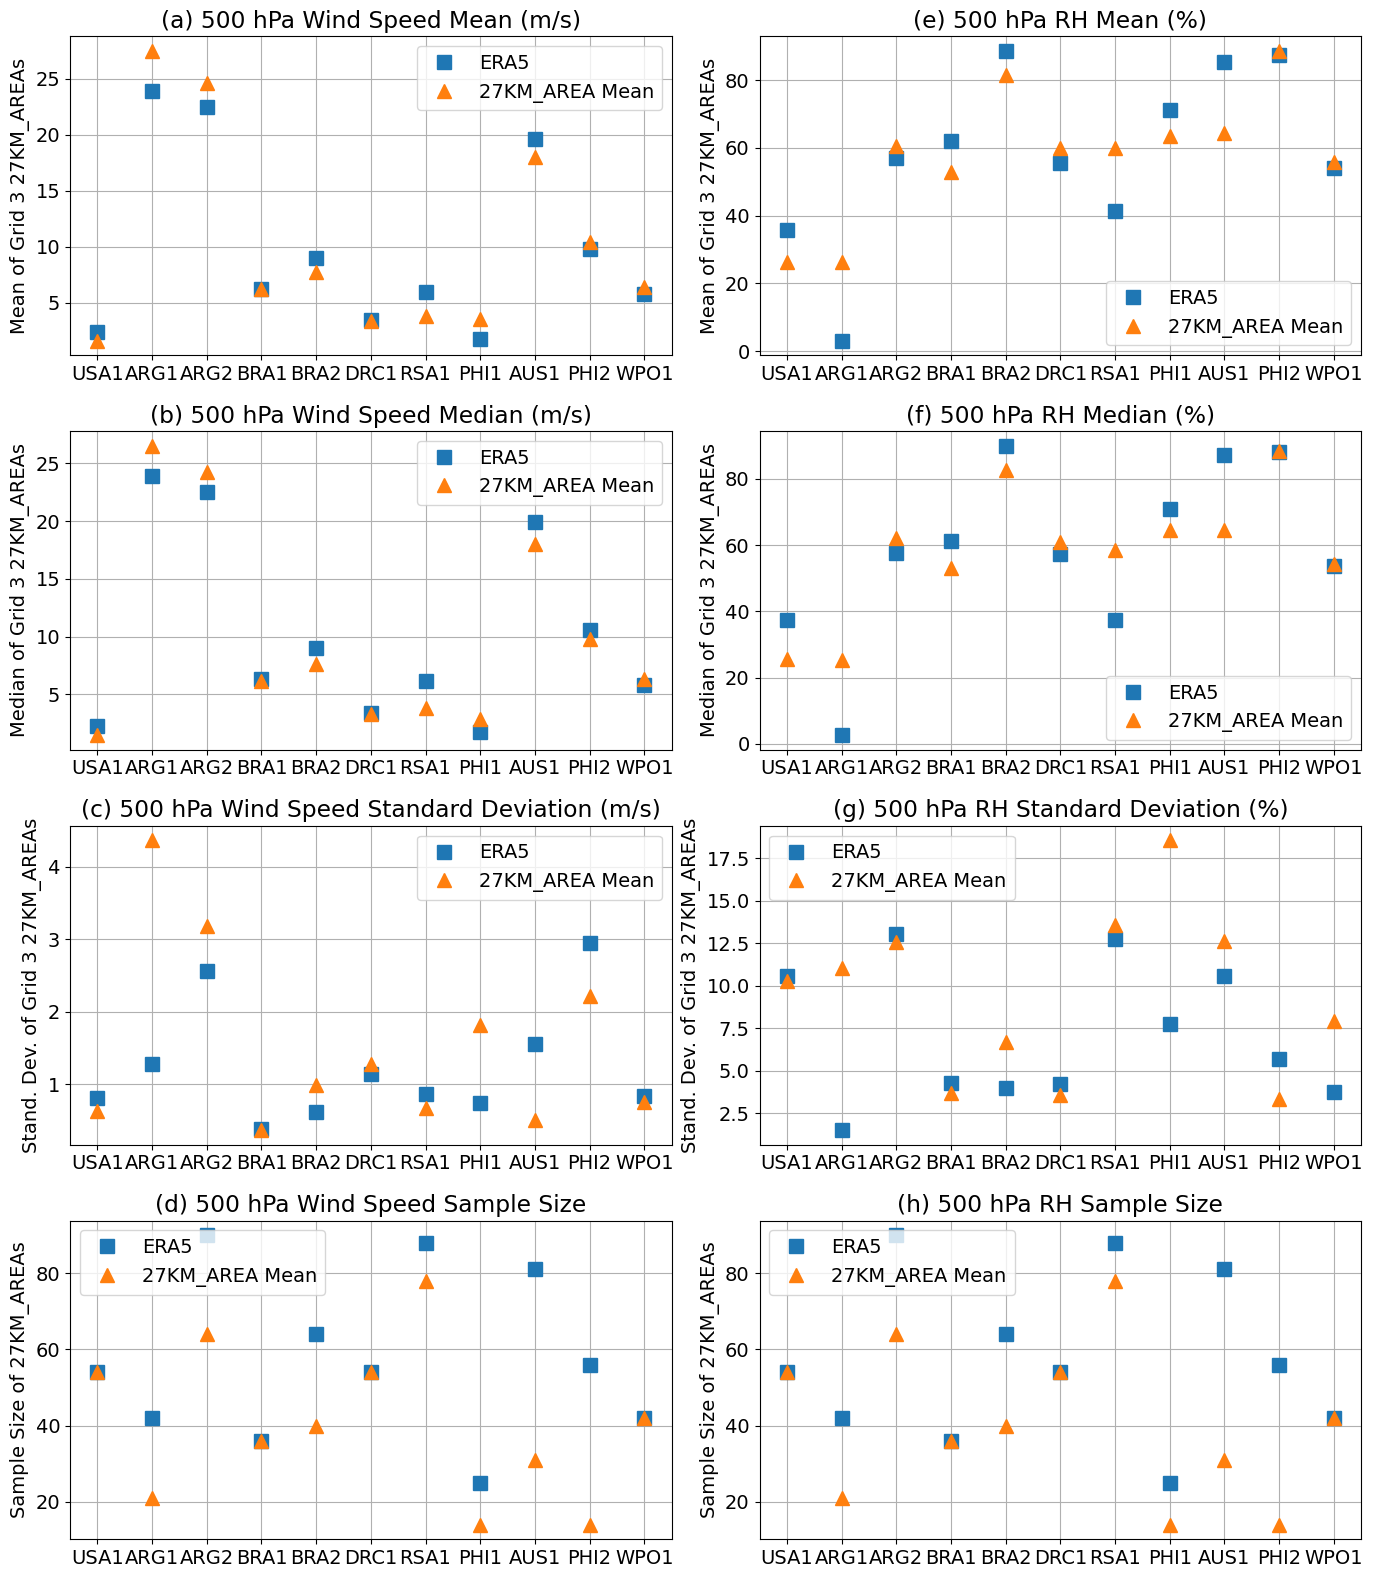

In [22]:
# Plot Comparisons 

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(4,2,figsize=[14,16])
i = 0
varname = 'spd'
mplvl = 500
ss = 10
print(dist_cnt[varname,mplvl][0,:])
print(dist_cnt[varname,mplvl][1,:])

ax[0,i].plot(dist_avg[varname,mplvl][0,:],'s',markersize=ss,label='ERA5') # ERA5 data
ax[0,i].plot(dist_avg[varname,mplvl][1,:],'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[0,i].set_xticks(np.arange(0,len(cases)))
ax[0,i].set_ylabel('Mean of Grid 3 27KM_AREAs')
ax[0,i].set_xticklabels(casesn)
ax[0,i].set_title('(a) 500 hPa Wind Speed Mean (m/s)')
ax[0,i].grid()
ax[0,i].legend()

ax[1,i].plot(dist_med[varname,mplvl][0,:],'s',markersize=ss,label='ERA5') # ERA5 data
ax[1,i].plot(dist_med[varname,mplvl][1,:],'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[1,i].set_xticks(np.arange(0,len(cases)))
ax[1,i].set_ylabel('Median of Grid 3 27KM_AREAs')
ax[1,i].set_xticklabels(casesn)
ax[1,i].set_title('(b) 500 hPa Wind Speed Median (m/s)')
ax[1,i].grid()
ax[1,i].legend()

ax[2,i].plot(dist_std[varname,mplvl][0,:],'s',markersize=ss,label='ERA5') # ERA5 data
ax[2,i].plot(dist_std[varname,mplvl][1,:],'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[2,i].set_xticks(np.arange(0,len(cases)))
ax[2,i].set_ylabel('Stand. Dev. of Grid 3 27KM_AREAs')
ax[2,i].set_title('(c) 500 hPa Wind Speed Standard Deviation (m/s)')
ax[2,i].set_xticklabels(casesn)
ax[2,i].grid()
ax[2,i].legend()

ax[3,i].plot(dist_cnt[varname,mplvl][0,:],'s',markersize=ss,label='ERA5') # ERA5 data
ax[3,i].plot(dist_cnt[varname,mplvl][1,:],'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[3,i].set_xticks(np.arange(0,len(cases)))
ax[3,i].set_ylabel('Sample Size of 27KM_AREAs')
ax[3,i].set_title('(d) 500 hPa Wind Speed Sample Size')
ax[3,i].set_xticklabels(casesn)
ax[3,i].grid()
ax[3,i].legend()

i = 1
varname = 'rh'
mplvl = 500

ax[0,i].plot(dist_avg[varname,mplvl][0,:]*100,'s',markersize=ss,label='ERA5') # ERA5 data
ax[0,i].plot(dist_avg[varname,mplvl][1,:]*100,'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[0,i].set_xticks(np.arange(0,len(cases)))
ax[0,i].set_ylabel('Mean of Grid 3 27KM_AREAs')
ax[0,i].set_xticklabels(casesn)
ax[0,i].set_title('(e) 500 hPa RH Mean (%)')
ax[0,i].grid()
ax[0,i].legend()

ax[1,i].plot(dist_med[varname,mplvl][0,:]*100,'s',markersize=ss,label='ERA5') # ERA5 data
ax[1,i].plot(dist_med[varname,mplvl][1,:]*100,'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[1,i].set_xticks(np.arange(0,len(cases)))
ax[1,i].set_ylabel('Median of Grid 3 27KM_AREAs')
ax[1,i].set_xticklabels(casesn)
ax[1,i].set_title('(f) 500 hPa RH Median (%)')
ax[1,i].grid()
ax[1,i].legend()

ax[2,i].plot(dist_std[varname,mplvl][0,:]*100,'s',markersize=ss,label='ERA5') # ERA5 data
ax[2,i].plot(dist_std[varname,mplvl][1,:]*100,'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[2,i].set_xticks(np.arange(0,len(cases)))
ax[2,i].set_ylabel('Stand. Dev. of Grid 3 27KM_AREAs')
ax[2,i].set_title('(g) 500 hPa RH Standard Deviation (%)')
ax[2,i].set_xticklabels(casesn)
ax[2,i].grid()
ax[2,i].legend()

ax[3,i].plot(dist_cnt[varname,mplvl][0,:],'s',markersize=ss,label='ERA5') # ERA5 data
ax[3,i].plot(dist_cnt[varname,mplvl][1,:],'^',markersize=ss,label='27KM_AREA Mean') # model data
ax[3,i].set_xticks(np.arange(0,len(cases)))
ax[3,i].set_ylabel('Sample Size of 27KM_AREAs')
ax[3,i].set_title('(h) 500 hPa RH Sample Size')
ax[3,i].set_xticklabels(casesn)
ax[3,i].grid()
ax[3,i].legend()

plt.tight_layout()
plt.savefig('/tempest/pmarin/ENV/CMP_ERA5_Model/Plots/Manuscript_S4.png')
plt.savefig('/tempest/pmarin/ENV/CMP_ERA5_Model/Plots/Manuscript_S4.pdf')
plt.savefig(plotpath+'/Manuscript_S4.png')
plt.savefig(plotpath+'/Manuscript_S4.pdf')


In [24]:
np.sum(dist_cnt[varname,mplvl][1,:])

448.0

In [25]:
varname

'rh'